In [104]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Leemos nuestros datasets y creamos el Dataframe con el que vamos a trabajar "hospitalizaciones" y tambien el "hospitalizaciones_pred" con el que haremos las predicciones para la entrega

In [105]:
hospitalizaciones = pd.read_csv("datasets/hospitalizaciones_train.csv", decimal=".")
hospitalizaciones_pred = pd.read_csv("datasets/hospitalizaciones_test.csv", decimal=".")

Para comenzar con nuestro EDA controlamos primero que no haya duplicados

In [106]:
hospitalizaciones.drop_duplicates(inplace=True)
hospitalizaciones_pred.drop_duplicates(inplace=True)

Como podemos observar a continuación, no poseemos valores nulos en nuestros datos, pero sí que tenemos unas cuantas columnas no numéricas que debemos proceder a estandarizar

In [107]:
hospitalizaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

### `Descripción de las dimensiones`

**Available Extra Rooms in Hospital:** Habitaciones adicionales disponibles en el hospital. Una habitación no es igual a un paciente, pueden ser individuales o compartidas.  
**Department:** Área de atención a la que ingresa el paciente.  
**Ward_Facility_Code:** Código de la habitación del paciente.  
**doctor_name:** Nombre de el/la doctor/a a cargo del paciente.  
**staff_available:** Cantidad de personal disponible al momento del ingreso del paciente.  
**patientid:** Identificador del paciente.  
**Age:** Edad del paciente.  
**gender:** Género del paciente.  
**Type of Admission:** Tipo de ingreso registrado según la situación de ingreso del paciente.  
**Severity of Illness:** Gravedad de la enfermedad/condición/estado del paciente al momento del ingreso.  
**health_conditions:** Condiciones de salud del paciente.  
**Visitors with Patient:** Cantidad de visitantes registrados para el paciente.  
**Insurance:** Indica si la persona posee o no seguro de salud.  
**Admission_Deposit:** Pago realizado a nombre del paciente, con el fin de cubrir los costos iniciales de internación.  
**Stay (in days):** Días registrados de estancia hospitalaria.​  

Para empezar definimos que un paciente posee estancia hospitalaria prolongada si ha estado hospitalizado más de 8 días. Esta información se encuentra en la columna "Stay (in days)", por lo cual ya podemos crear nuestra columna target que se llamara 'pred' que tendrá 0 para estadías cortas y 1 para estadías largas.  
Ahora si eliminamos la columna "Stay (in days)" y también la columna "patientid" ya que no aporta nada a nuestro modelo y lo único que hace es complejizarlo.

In [108]:
hospitalizaciones['pred'] = hospitalizaciones['Stay (in days)'].apply(lambda x: 1 if x > 8 else 0)
hospitalizaciones.drop("Stay (in days)", inplace=True, axis=1)
hospitalizaciones.drop("patientid", inplace=True, axis=1)

# Lo mismo en hospitalizaciones_pred
hospitalizaciones_pred.drop("patientid", inplace=True, axis=1)

Como podemos observar a continuación, nos encontramos con un dataset bastante balanceado por lo cual no debemos tomar ninguna acción para modificar esto

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

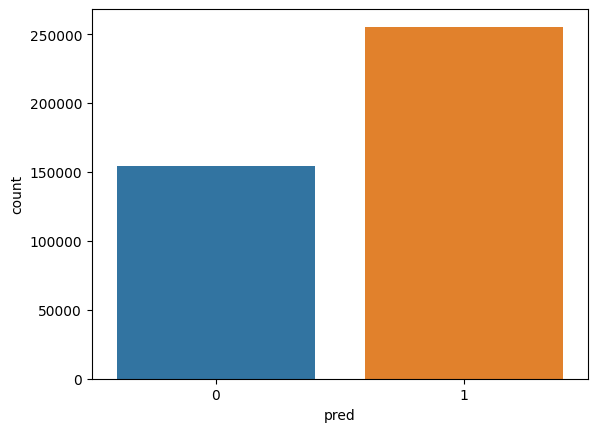

In [110]:
sns.countplot(x='pred', data=hospitalizaciones) 
plt.show()

### `Feature Encoding`

Aca empiezan las conversiones de atributos categoricos a valores numericos

In [111]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ohe = OneHotEncoder(dtype=int)
oe = OrdinalEncoder()

Seleccionamos las columnas categoricas que tienen mas de 2 posibles valores en su interior para realizarles un OneHotEncoder

In [112]:
feature_arr = ohe.fit_transform(hospitalizaciones[['Department','Ward_Facility_Code', 'doctor_name', 'health_conditions']]).toarray()
feature_labels = ohe.categories_
feature_labels = np.concatenate(feature_labels)

Agregamos esas nuevas columnas al DataFrame original

In [113]:
features = pd.DataFrame(feature_arr, columns=feature_labels)
hospitalizaciones = pd.concat([hospitalizaciones, features], axis=1)

Realizamos todas las mismas conversiones que se hicieron anteriormente pero en nuestro DataFrame a predecir (hospitalizaciones_pred)

In [114]:
feature_arr_pred = ohe.fit_transform(hospitalizaciones_pred[['Department','Ward_Facility_Code', 'doctor_name', 'health_conditions']]).toarray()
feature_labels_pred = ohe.categories_
feature_labels_pred = np.concatenate(feature_labels_pred)

features_pred = pd.DataFrame(feature_arr_pred, columns=feature_labels_pred)
hospitalizaciones_pred = pd.concat([hospitalizaciones_pred, features_pred], axis=1)

Para el resto de atributos categóricos que son de tipo ordinal vamos a utilizar el OrdinalEncoder

In [115]:
oe = OrdinalEncoder(categories=[['0-10', '11-20', '21-30', '31-40', '41-50', '41-50', '51-60', '61-70', '71-80', '81-90' ,'91-100']], dtype=int)
hospitalizaciones["Age"] = oe.fit_transform(hospitalizaciones["Age"].values.reshape(-1,1))
hospitalizaciones_pred["Age"] = oe.fit_transform(hospitalizaciones_pred["Age"].values.reshape(-1,1))

In [116]:
oe = OrdinalEncoder(dtype=int)
hospitalizaciones["gender"] = oe.fit_transform(hospitalizaciones["gender"].values.reshape(-1,1))
hospitalizaciones_pred["gender"] = oe.fit_transform(hospitalizaciones_pred["gender"].values.reshape(-1,1))

In [117]:
oe = OrdinalEncoder(categories=[['Emergency', 'Trauma', 'Urgent']], dtype=int)
hospitalizaciones["Type of Admission"] = oe.fit_transform(hospitalizaciones["Type of Admission"].values.reshape(-1,1))
hospitalizaciones_pred["Type of Admission"] = oe.fit_transform(hospitalizaciones_pred["Type of Admission"].values.reshape(-1,1))

In [118]:
oe = OrdinalEncoder(categories=[['Extreme', 'Moderate', 'Minor']], dtype=int)
hospitalizaciones["Severity of Illness"] = oe.fit_transform(hospitalizaciones["Severity of Illness"].values.reshape(-1,1))
hospitalizaciones_pred["Severity of Illness"] = oe.fit_transform(hospitalizaciones_pred["Severity of Illness"].values.reshape(-1,1))

In [119]:
oe = OrdinalEncoder(dtype=int)
hospitalizaciones["Insurance"] = oe.fit_transform(hospitalizaciones["Insurance"].values.reshape(-1,1))
hospitalizaciones_pred["Insurance"] = oe.fit_transform(hospitalizaciones_pred["Insurance"].values.reshape(-1,1))

Y Ahora eliminamos las columnas categoricas utilizadas para las conversiones

In [120]:
hospitalizaciones.drop("Department", inplace=True, axis=1)
hospitalizaciones.drop("Ward_Facility_Code", inplace=True, axis=1)
hospitalizaciones.drop("doctor_name", inplace=True, axis=1)
hospitalizaciones.drop("health_conditions", inplace=True, axis=1)

hospitalizaciones_pred.drop("Department", inplace=True, axis=1)
hospitalizaciones_pred.drop("Ward_Facility_Code", inplace=True, axis=1)
hospitalizaciones_pred.drop("doctor_name", inplace=True, axis=1)
hospitalizaciones_pred.drop("health_conditions", inplace=True, axis=1)

Como podemos ver a continuacion todos nuestros atributos son de tipo numerico

In [59]:
hospitalizaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410000 entries, 0 to 409999
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   staff_available                    410000 non-null  int64  
 2   Age                                410000 non-null  int32  
 3   gender                             410000 non-null  int32  
 4   Type of Admission                  410000 non-null  int32  
 5   Severity of Illness                410000 non-null  int32  
 6   Visitors with Patient              410000 non-null  int64  
 7   Insurance                          410000 non-null  int32  
 8   Admission_Deposit                  410000 non-null  float64
 9   pred                               410000 non-null  int64  
 10  TB & Chest disease                 410000 non-null  int32  
 11  anesthesia                         4100

### `Pairplot`

En esta instancia, emplearemos un paso fundamental dentro de todo **EDA** que nos muestra todas las relaciones entre las variables cuantitativas del dataframe que estemos trabajando. La importancia de este paso radica en que nos permite elegir las mejores variables predictoras para nuestro modelo. Si queremos predecir la variedad de una flor, lo más racional sería seleccionar aquellos atributos que tengan una mayor incidencia en que una flor pertenezca a una u otra categoría.

Como se desprende de lo comentado, este paso es condición _sine qua non_ en cualquier **Análisis Exploratorio de Datos** que emprendan.

In [60]:
columnas = list(hospitalizaciones.columns)

Creo diferentes agrupaciones de variables para ir viendo sus relaciones con "pred" por separado

In [61]:
# Condiciones del hospital
columnas[0] = ['Available Extra Rooms in Hospital', 'staff_available', 'pred']

# Condiciones del paciente
columnas[1] = ['Age', 'gender', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Insurance', 'Admission_Deposit', 'pred']

# Departamentos
columnas[2] = ['TB & Chest disease', 'anesthesia', 'gynecology', 'radiotherapy', 'surgery', 'pred']

# Habitacion del paciente
columnas[3] = ['A', 'B', 'C', 'D', 'E', 'F', 'pred']

# Nombre del Doctor
columnas[4] = ['Dr Isaac', 'Dr John', 'Dr Mark', 'Dr Nathan', 'Dr Olivia', 'Dr Sam', 'Dr Sarah', 'Dr Simon', 'Dr Sophia', 'Asthama', 'pred']

# Condicion de salud del paciente
columnas[5] = ['Diabetes', 'Heart disease', 'High Blood Pressure', 'None', 'Other', 'pred']

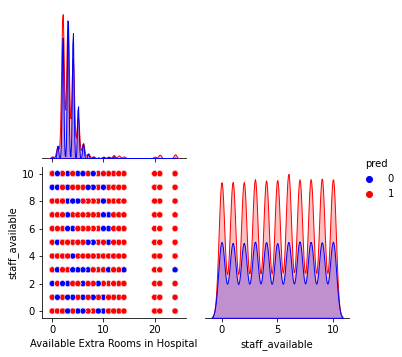

In [39]:
# Condiciones del hospital
sns.pairplot(hospitalizaciones[columnas[0]], hue="pred", palette = ['b', 'r'], corner=True)
plt.show()

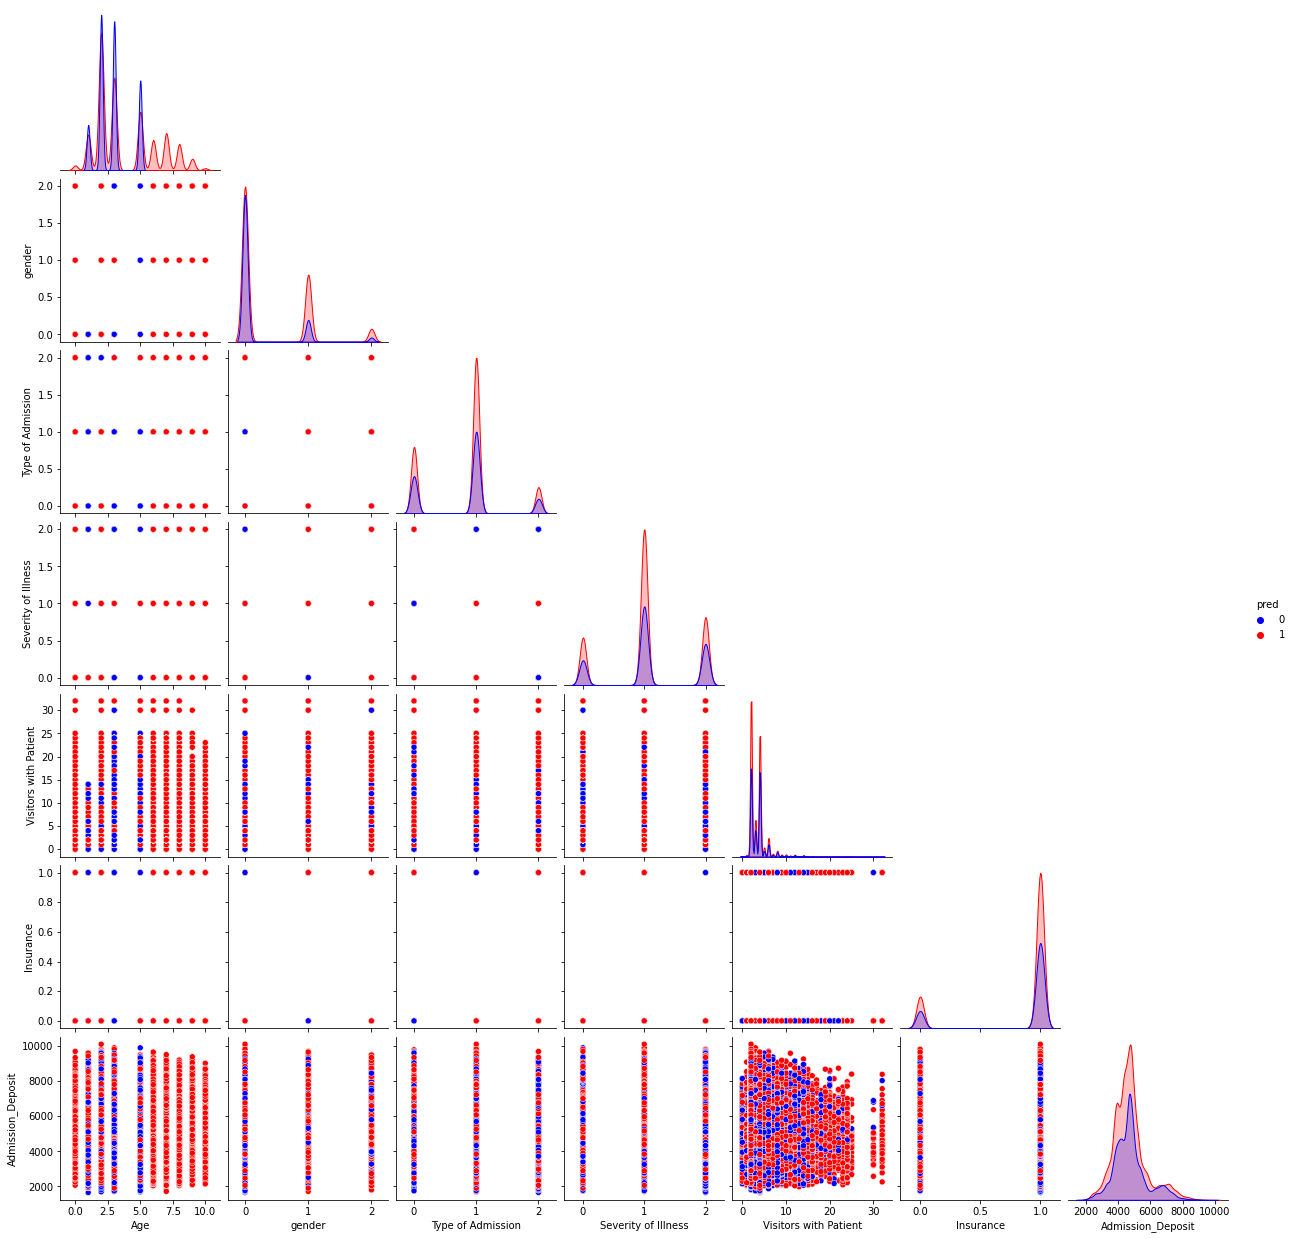

In [40]:
# Condiciones del paciente
sns.pairplot(hospitalizaciones[columnas[1]], hue="pred", palette = ['b', 'r'], corner=True)
plt.show()

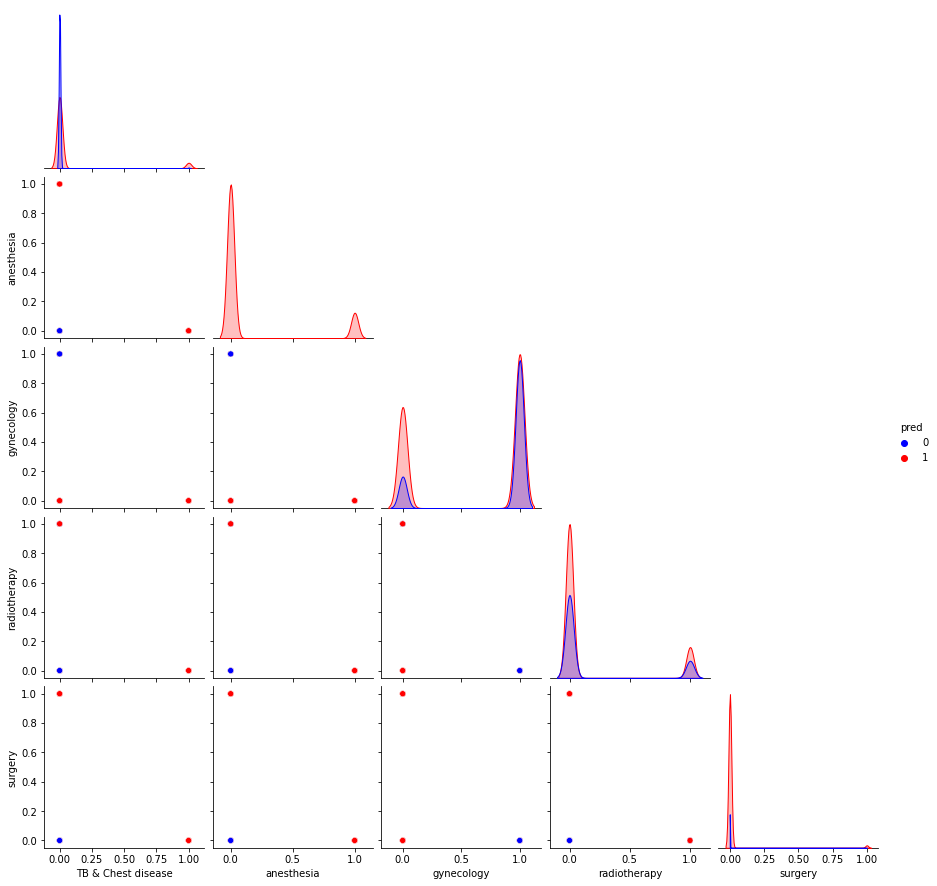

In [41]:
# Departamentos
sns.pairplot(hospitalizaciones[columnas[2]], hue="pred", palette = ['b', 'r'], corner=True)
plt.show()

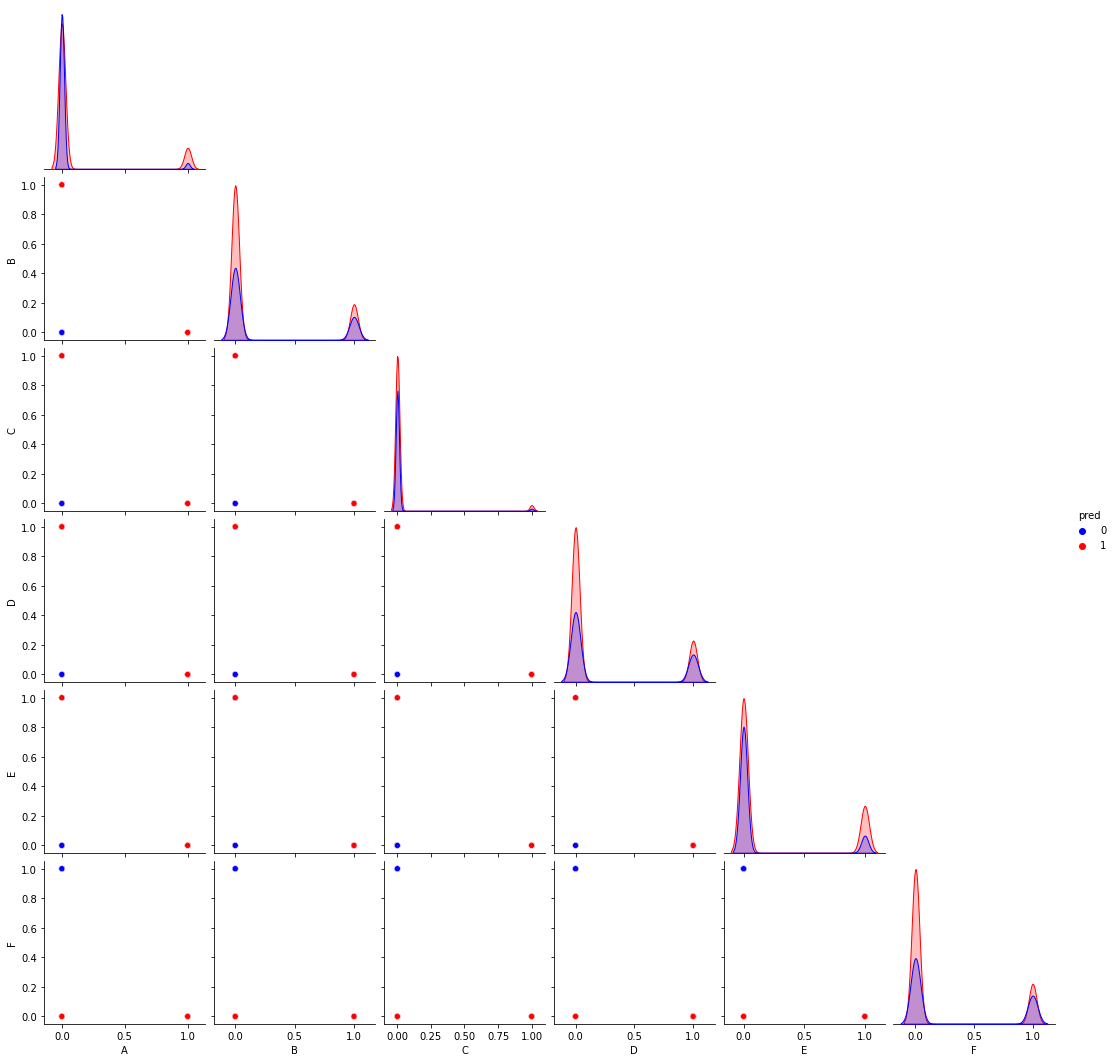

In [42]:
# Habitacion del paciente
sns.pairplot(hospitalizaciones[columnas[3]], hue="pred", palette = ['b', 'r'], corner=True)
plt.show()

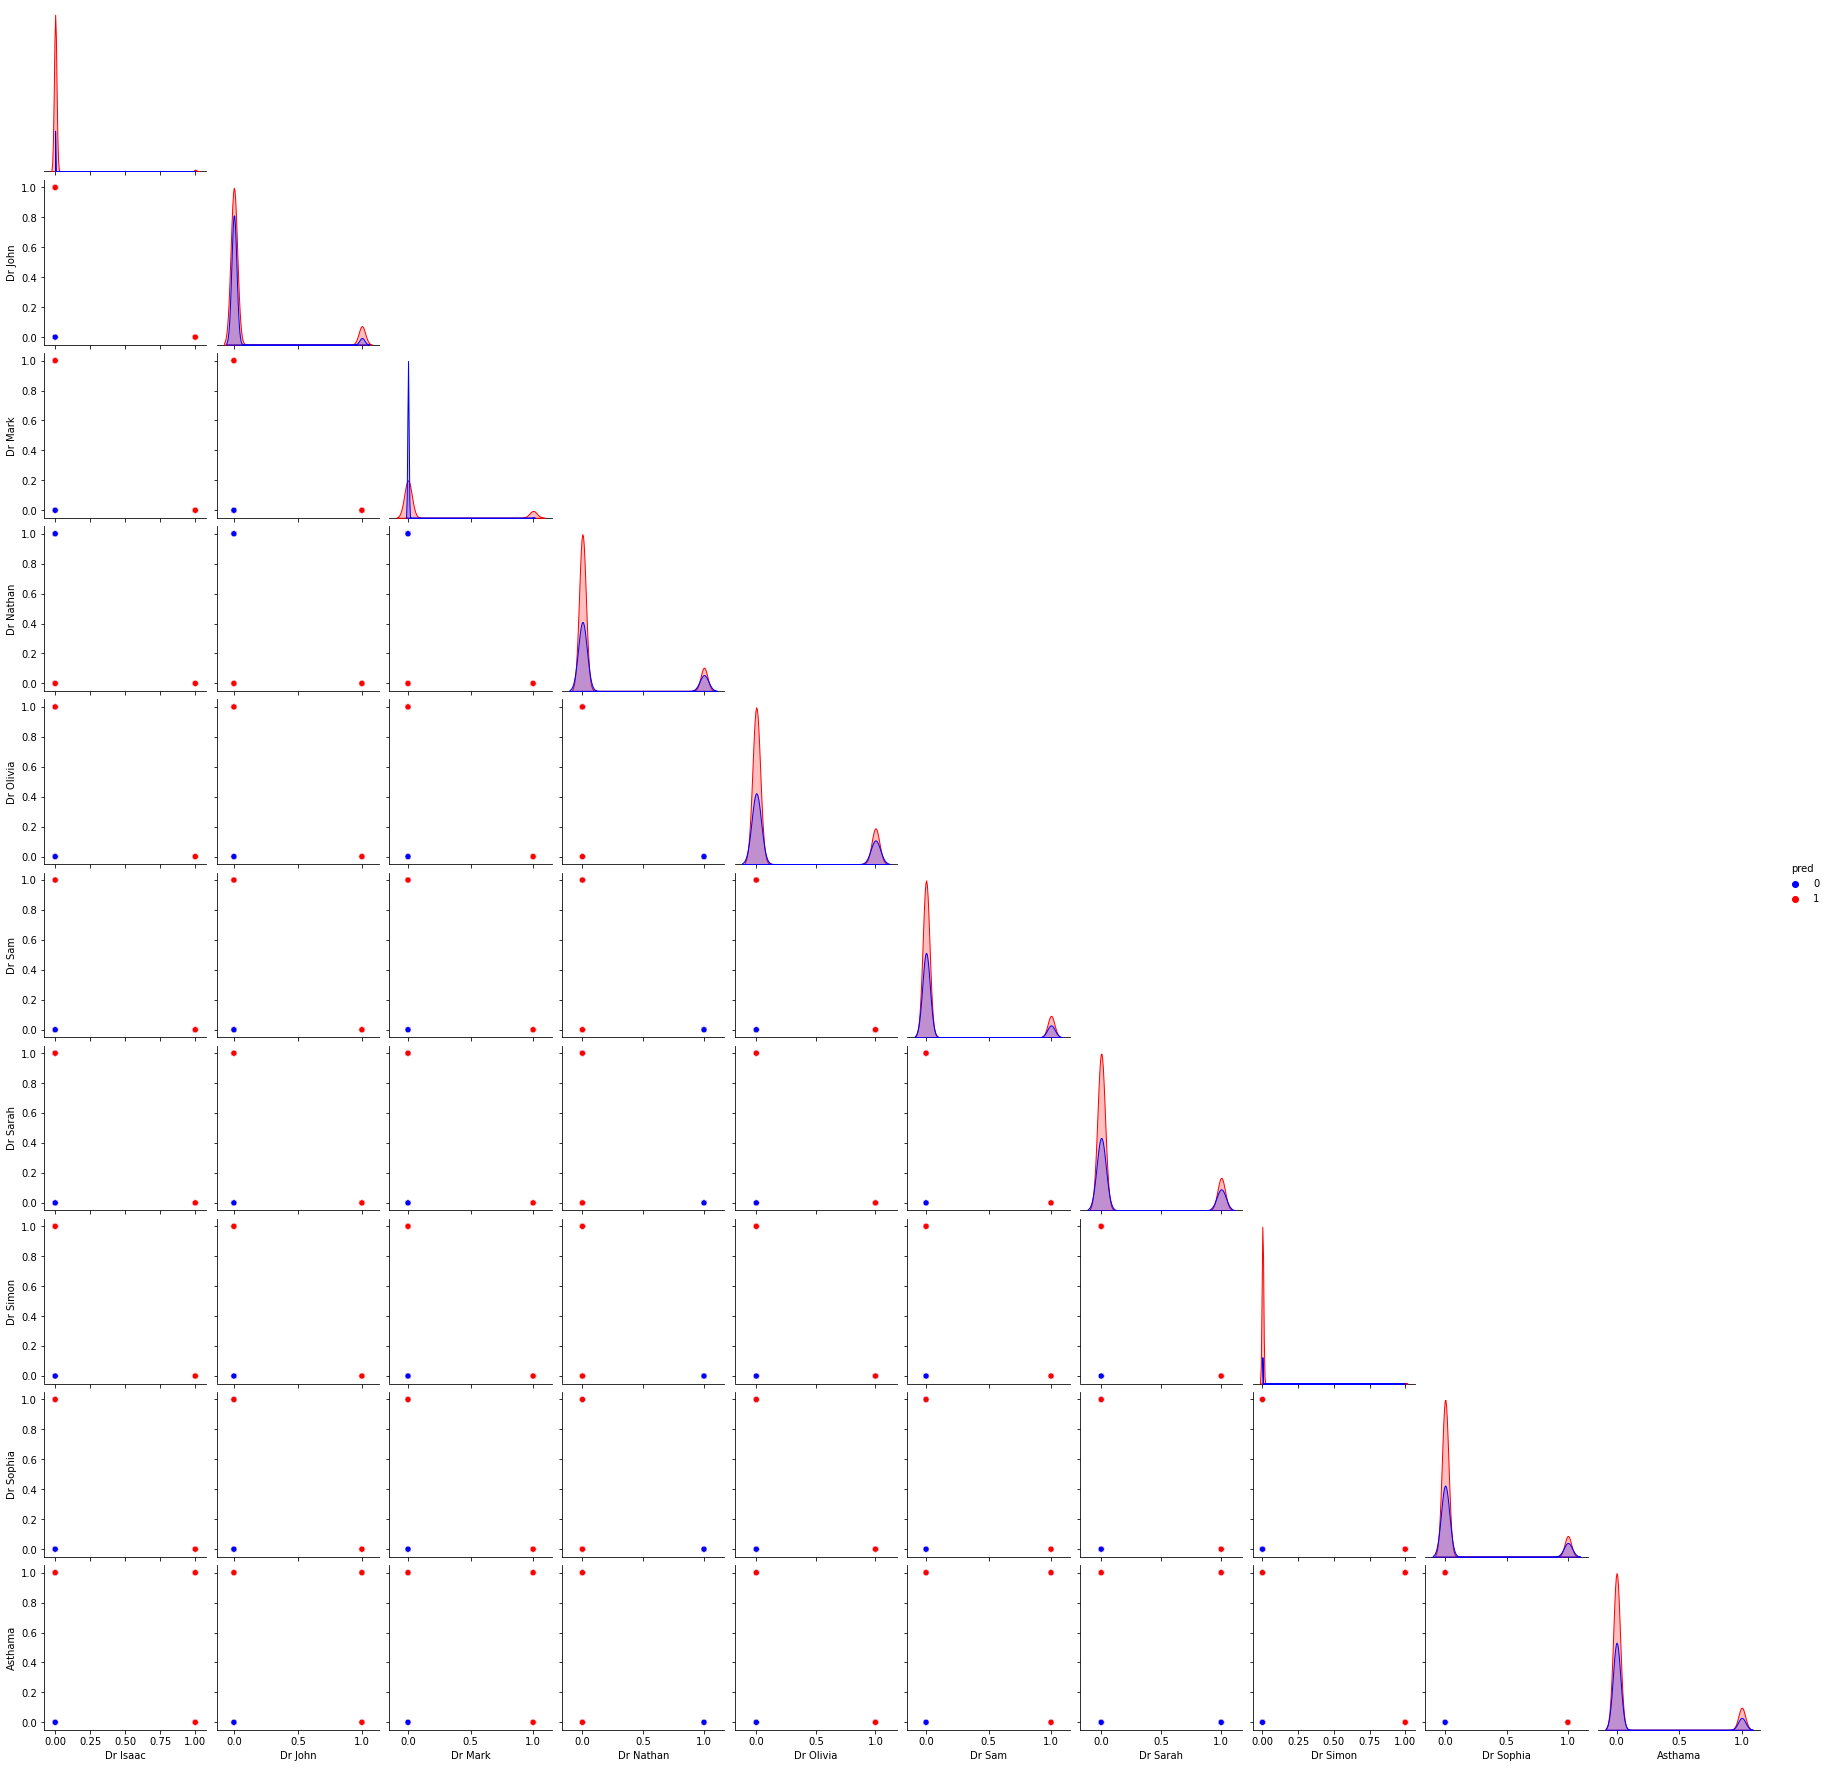

In [43]:
# Nombre del Doctor
sns.pairplot(hospitalizaciones[columnas[4]], hue="pred", palette = ['b', 'r'], corner=True)
plt.show()

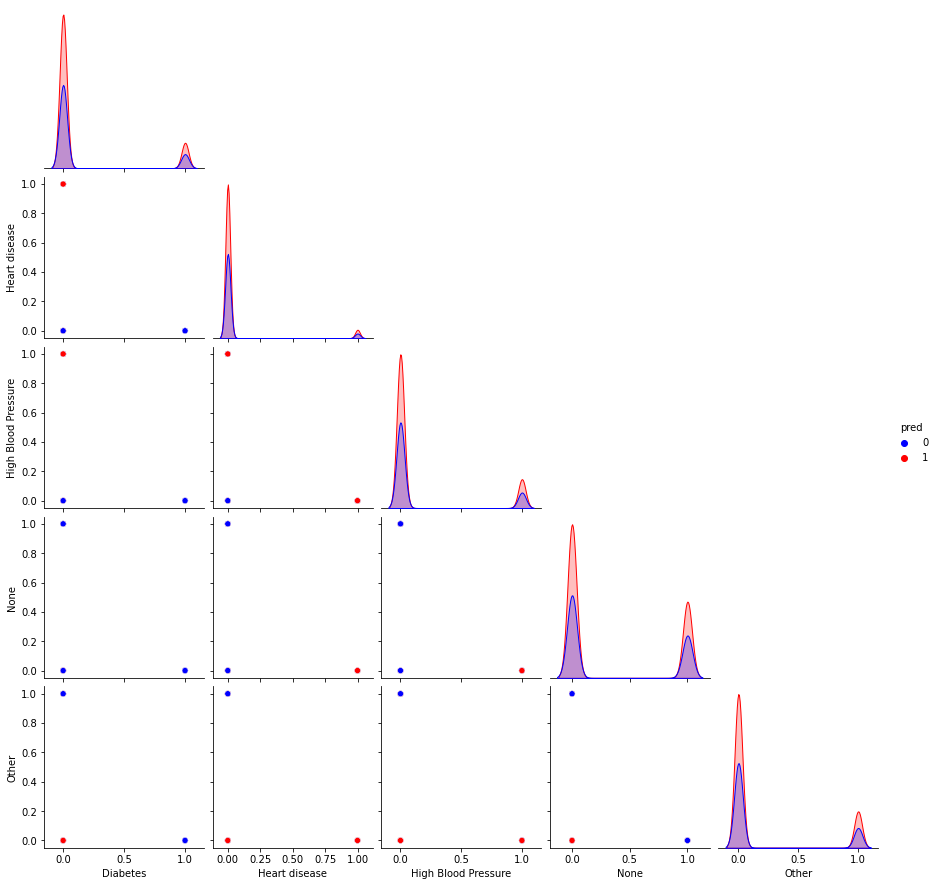

In [44]:
# Condicion de salud del paciente
sns.pairplot(hospitalizaciones[columnas[5]], hue="pred", palette = ['b', 'r'], corner=True)
plt.show()

Graficamos un mapa de calor mostrando aquellos atributos que tienen una mejor correlacion con nuestra variable objetivo (pred)

<AxesSubplot: >

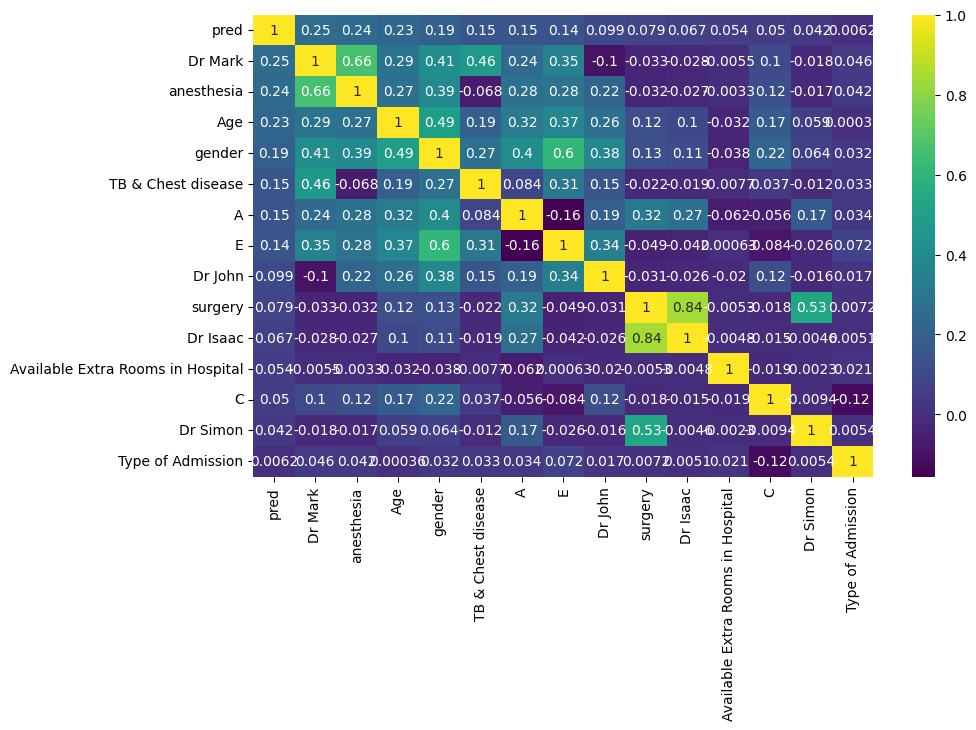

In [121]:
target = 'pred'
k = 15
numerical_feature_columns = list(hospitalizaciones._get_numeric_data().columns)
cols = hospitalizaciones[numerical_feature_columns].corr().nlargest(k, target)[target].index
cm = hospitalizaciones[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap='viridis')

Separamos nuestros datos en entrenamiento (x_train, y_train) y testeo (x_test, y_test)

In [122]:
from sklearn.model_selection import train_test_split

X = hospitalizaciones.loc[:, hospitalizaciones.columns != target]
Y = hospitalizaciones.loc[:, hospitalizaciones.columns == target]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

## `Pipeline`
El pipeline es una forma de codificar y automatizar el workflow necesario para producir un modelo de Machine Learning. Los pipelines en ML constan de varios pasos secuenciales que hacen de todo, desde la extracción y el preprocesamiento de datos hasta el entrenamiento y la implementación de modelos.

En definitiva, nos ayuda a automatizar un flujo de trabajo de Machine Learning.

A continuación, crearemos algunos pipelines. Los modelos que usaremos serán:
- Decision Tree
- Random Forest
- CatBoost
- XGBoost
- LightGBM

Respecto al preprocesamiento, aplicaremos un escalado de datos con `Standard Scaler`.

In [124]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [68]:
# Creamos el primer pipeline
pipe_dtr = Pipeline([('scl', StandardScaler()),
			('clf', DecisionTreeRegressor(random_state=0))])

In [69]:
# Creamos el segundo pipeline
pipe_rfr = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestRegressor(random_state=0))])

In [70]:
# Creamos el tercer pipeline
pipe_cbr = Pipeline([('scl', StandardScaler()),
			('clf', CatBoostRegressor(random_state=0))])

In [71]:
# Creamos el cuarto pipeline
pipe_xgbr = Pipeline([('scl', StandardScaler()),
			('clf', XGBRegressor(random_state=0))])

In [72]:
# Creamos el quinto pipeline
pipe_lgbmr = Pipeline([('scl', StandardScaler()),
			('clf', LGBMRegressor(random_state=0))])

In [73]:
# Los guardamos en una lista
pipelines = [pipe_dtr, pipe_rfr, pipe_cbr, pipe_xgbr, pipe_lgbmr]

# Hacemos un diccionario para fines organizativos
pipe_dict = {0: 'Decision Tree', 1: 'Random Forest', 2: 'CatBoost', 3: 'XGBoost', 4: 'LightGBM'}

In [76]:
# Entrenamos los modelos
for pipe in pipelines:
	pipe.fit(x_train, np.ravel(y_train))

Learning rate set to 0.09943
0:	learn: 0.4712989	total: 15.6ms	remaining: 15.6s
1:	learn: 0.4605805	total: 28.9ms	remaining: 14.4s
2:	learn: 0.4516113	total: 41.8ms	remaining: 13.9s
3:	learn: 0.4441540	total: 55.1ms	remaining: 13.7s
4:	learn: 0.4380721	total: 67.6ms	remaining: 13.4s
5:	learn: 0.4329375	total: 80.8ms	remaining: 13.4s
6:	learn: 0.4286588	total: 93.9ms	remaining: 13.3s
7:	learn: 0.4251961	total: 107ms	remaining: 13.2s
8:	learn: 0.4223328	total: 120ms	remaining: 13.2s
9:	learn: 0.4200122	total: 133ms	remaining: 13.1s
10:	learn: 0.4180191	total: 147ms	remaining: 13.2s
11:	learn: 0.4165568	total: 159ms	remaining: 13.1s
12:	learn: 0.4151647	total: 172ms	remaining: 13s
13:	learn: 0.4140400	total: 184ms	remaining: 12.9s
14:	learn: 0.4130948	total: 198ms	remaining: 13s
15:	learn: 0.4123357	total: 210ms	remaining: 12.9s
16:	learn: 0.4115291	total: 224ms	remaining: 13s
17:	learn: 0.4109043	total: 238ms	remaining: 13s
18:	learn: 0.4104237	total: 252ms	remaining: 13s
19:	learn: 0.41

In [125]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [79]:
# Evaluamos
for idx, val in enumerate(pipelines):
    predict = [1 if prob > 0.5 else 0 for prob in np.ravel(val.predict(x_test))]
    print(f"{pipe_dict[idx]} = Recall : {recall_score(y_test, predict)} - Accuracy: {accuracy_score(y_test, predict)}")
	#print('%s Pipeline Accuracy en test: %.3f' % (pipe_dict[idx], val.score(x_test, y_test)))

Decision Tree = Recall : 0.8058245488654636 - Accuracy: 0.7591722099039172
Random Forest = Recall : 0.848990530641415 - Accuracy: 0.8042276422764227
CatBoost = Recall : 0.8467035912095766 - Accuracy: 0.7719807834441981
XGBoost = Recall : 0.8451432314930618 - Accuracy: 0.7718920916481892
LightGBM = Recall : 0.8498957774998511 - Accuracy: 0.7602512934220251


Como podemos observar, obtuvimos los mejores valores con un "Random Forest". Vamos a tratar de mejorar aun mas ese score con un GridSearchCV

In [126]:
from sklearn.model_selection import GridSearchCV
rf_model = RandomForestRegressor()

In [90]:
# Defino unos cuantos hiperparametros que vamos a utilizar
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
max_features = ['auto', 'sqrt', 1.0]
max_depth = [None,2,4]
min_samples_split = [2,5]
min_samples_leaf = [1,2]
bootstrap = [True, False]

In [92]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
hospitalizaciones_pred = scaler.transform(hospitalizaciones_pred)

In [93]:
param_grid_forest = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [96]:
rf_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid_forest, cv=3, verbose=2, n_jobs=-1)

In [ ]:
rf_grid.fit(x_train, y_train)

Seleccionamos el mejor modelo y lo evaluamos

In [98]:
rf_model = rf_grid.best_estimator_

RandomForestRegressor(max_features='auto', min_samples_leaf=2,
                      min_samples_split=5)

In [151]:
re_model = RandomForestRegressor(max_features='auto', min_samples_leaf=2, min_samples_split=5)

In [152]:
rf_model.fit(x_train, y_train)

RandomForestRegressor()

Modelo mas balanceado

In [153]:
predict = [1 if prob > 0.5 else 0 for prob in np.ravel(rf_model.predict(x_test))]
print(f"Recall : {recall_score(y_test, predict)} - Accuracy: {accuracy_score(y_test, predict)}")

Recall : 0.8485021737835745 - Accuracy: 0.8036733185513674


Modelo mejor Recall

In [155]:
predict = [1 if prob > 0.1 else 0 for prob in np.ravel(rf_model.predict(x_test))]
print(f"Recall : {recall_score(y_test, predict)} - Accuracy: {accuracy_score(y_test, predict)}")

Recall : 0.9960812339944017 - Accuracy: 0.7132815964523281


In [156]:
predict = [1 if prob > 0.1 else 0 for prob in np.ravel(rf_model.predict(hospitalizaciones_pred))]
pd.DataFrame(predict).to_csv(f'datasets/Damiano7.csv', header = ['pred'], index = False)

------------------------

Testeamos una Red Neuronal con Keras-TensorFlow

In [159]:
import tensorflow.compat.v1 as tf

In [157]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [160]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [161]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
)

In [162]:
# epochs = 200
history = model.fit(x_train_scaled, y_train.to_numpy(), epochs=200)

Epoch 1/200
8585/8585 [==============================] - 11s 1ms/step - loss: 0.4722 - recall: 0.8903 - accuracy: 0.6997
Epoch 2/200
8585/8585 [==============================] - 10s 1ms/step - loss: 0.4589 - recall: 0.8796 - accuracy: 0.7139
Epoch 3/200
8585/8585 [==============================] - 10s 1ms/step - loss: 0.4552 - recall: 0.8718 - accuracy: 0.7185
Epoch 4/200
8585/8585 [==============================] - 10s 1ms/step - loss: 0.4514 - recall: 0.8686 - accuracy: 0.7248
Epoch 5/200
8585/8585 [==============================] - 10s 1ms/step - loss: 0.4485 - recall: 0.8613 - accuracy: 0.7283
Epoch 6/200
8585/8585 [==============================] - 10s 1ms/step - loss: 0.4460 - recall: 0.8621 - accuracy: 0.7320
Epoch 7/200
8585/8585 [==============================] - 10s 1ms/step - loss: 0.4423 - recall: 0.8525 - accuracy: 0.7365
Epoch 8/200
8585/8585 [==============================] - 10s 1ms/step - loss: 0.4398 - recall: 0.8519 - accuracy: 0.7394
Epoch 9/200
8585/8585 [=========

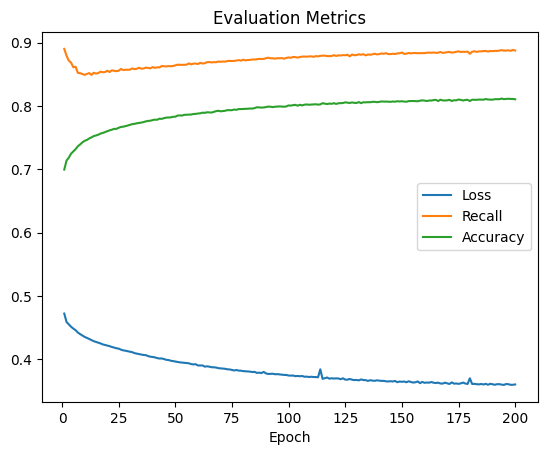

In [163]:
plt.plot(np.arange(1,201), history.history['loss'], label="Loss")
plt.plot(np.arange(1,201), history.history['recall'], label="Recall")
plt.plot(np.arange(1,201), history.history['accuracy'], label="Accuracy")
plt.title("Evaluation Metrics")
plt.xlabel("Epoch")
plt.legend()

In [164]:
loss, rec, acc = model.evaluate(x_test_scaled, y_test)

4229/4229 [==============================] - 3s 786us/step - loss: 0.6383 - recall: 0.8454 - accuracy: 0.7397


In [166]:
print(f"Model Loss (Test): {loss}")
print(f"Model Recall (Test): {rec}")
print(f"Model Accuracy (Test): {acc}")

Model Loss (Test): 0.638306200504303
Model Recall (Test): 0.8453576564788818
Model Accuracy (Test): 0.7397487163543701


In [167]:
hospitalizaciones_pred_scaled = scaler.transform(hospitalizaciones_pred)

In [172]:
predict = [1 if prob > 0.5 else 0 for prob in np.ravel(model.predict(hospitalizaciones_pred_scaled))]
pd.DataFrame(predict).to_csv(f'datasets/Damiano7.csv', header = ['pred'], index = False)

2813/2813 [==============================] - 2s 700us/step
